## Series: Credit Card Fraud

### Tutorial 1: Generating Candidate Models

**Tags: Foundations, Defining use cases, Building basic models**

We'll be starting this series with an analysis of a credit card fraud dataset. We're going to use this as an example of one of the most common enterprise use cases for machine learning: a learning to rank problem. In these cases we are looking to prioritize a set of records for escalation into some form of a review process. In this particular case, we'll be looking to identify payment records that might be fraudulent. In a company such as Visa or Stripe, records that score highly might be automatically blocked, while those with mid-level scores would be sent to a domain expert such as a fraud analyst for a decision. 

A key piece of this is the model that identifies the records of interest. Here we will look at several options for models that generate a probability measure or numeric score for each record. The advantage of this approach is that:
1. We can rank order the list to ensure that the highest value records are examined first, and
2. we can work our way as deeply into the list as we like, deciding to allocate more resources if we want to go deeper or less if we're capturing enough value with those records at the top.

You can download the dataset we're using from Kaggle: https://www.kaggle.com/dalpozz/creditcardfraud

Python packages we'll be making extensive use of:
- pandas
- numpy
- matplotlib
- sklearn
- keras/tensorflow

In [1]:
%matplotlib inline

import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

We're going to start with Logistic Regression Model. These models are the workhorses of the enterprise because they are fast to fit, give an interpretable rank ordering of coefficients, and are easily deployed in production settings. For those that aren't familiar, please see http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf for an in depth treatment.

This is a method "stolen" from statistics. The machine learning flavor is slightly different, in that we don't try to generate an inference or causal interpretation, but are looking solely for predictive performance.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
# Load the data. Don't forget to change this variable to your dataset location.
credit_dataset_location = '/Users/ianblumenfeld/data/credit_card_fraud/creditcard.csv'
data = pd.read_csv(credit_dataset_location)

In [4]:
# We're going to make a copy of the dataset to work with. This is because we'll be cutting this dataset in 
# a few different ways and I like to keep a clean copy of the initial one around. Let's also take a quick look at
# what's inside.
df = data.copy()
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Looking at the above you can see a couple of things:
1. There are almost 300K records.
2. Most of the transactions are valid. The fraud rate corresponds to the mean of the Class column, meaning that only 0.17% of the records are faudulent, or 492 total records. This situation (where one class is much more heavily represented in the data) is referred to as __unbalanced__.
3. Other than the time column, the other column labels are uninterpretable. This is because this particular dataset is has been dimensionally reduced through principal component analysis (PCA) before it was released to us. We are seeing only the 28 most significant components rather than the real-space features. This is actually the reason I chose this dataset- as the feature set we have available isn't in real-space, we don't have any temptation to try to interpret the coefficients and can focus entirely on the predictive value of the models.
4. The features are all pretty much on the same order, so we don't really need to rescale them.

In [5]:
# Now we'll do the slicing. We'll be grabbing the last 75K points to reserve for validation. These correspond to
# the later time period, so they have the additional benefit of being uncorrelated in time with the data we 
# use to train the model.
df['validation_set'] = df.index>df.shape[0]-75000
df_val = df[df.validation_set==True].copy()

# The earlier data we'll use for model training.
df = df[df.validation_set==False].copy()

In [6]:
# For the purposes of this tutorial, we're going to exlude the Time column. We'll come back to this at a later date.
# For those unfamiliar we're using a list comprehension to make the list of feature columns we'd like.
cols = [col for col in df.columns if col not in ['Class', 'validation_set', 'Time']]

# Create our feature and outcomes dataframe for model training.
features = df[cols]
outcomes = df[['Class']]

# Create our feature and outcomes dataframe for model validation.
features_val = df_val[cols]
outcomes_val = df_val[['Class']]

In [7]:
# Now we need to generate a random split of the training data for training of the model. This will help prevent us
# from overfitting.
x_train, x_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.33, random_state=15)

Now we'll fit the model. We'll use an L1 regularization penalty here. This forces the parameter values to take
on large values or be zero'ed out. This is a way to ensure that only those features with a strong contribution
to the outcome prediction are used. This is a good first order approach to see if a decent model is even achievable. It isn't usually the final model shipped though, because L1 can cost you some predictive power. Most folks will use it as a feature selection step, then drop the resulting feature choices into another algorithm (eg. Boosted Tree or LR with L2 regularization) or they'll use an elastic net (LR with L1 and L2 regularization terms). Because those add more hyperparameters to tune, I don't usually go there at the outset.

You can read more about regularization here: 
https://en.wikipedia.org/wiki/Regularization_(mathematics)

In [8]:
# The 'ravel' term here is just transforming the outcome data from n by 1 to 1 by n, which the fit methods prefer.
model = LogisticRegression(penalty='l1',).fit(x_train, np.ravel(y_train))

For evaluating our models we'll be using the Area under the Curve (AUC) of Receiver Operator Characteristic (ROC) Curve. This is the main metric we'll use for the learning to rank problem. There are a number of reasons this metric is most appropriate for these kinds of models:
1. For unbalanced datasets like this naive measures like accuracy work very poorly. This is because we can generate excellent accuracy by guessing "Not Fraud" for every record.
2. There is a direct interpretation for this value- roughly speaking it represents the probability that when we draw two samples at random from the data, that the one with the higher score actually is of higher "risk". 

Because of this, the AUC metric is the workhorse of enterprise ML. It directly measures the performance of the most commonly used data product.

In [23]:
auc_train = metrics.roc_auc_score(y_train,model.predict_proba(x_train.values)[:,1])
auc_test = metrics.roc_auc_score(y_test.values,model.predict_proba(x_test.values)[:,1])
auc_val = metrics.roc_auc_score(outcomes_val,model.predict_proba(features_val.values)[:,1])
print('AUC for the training set: %f' % auc_train)
print('AUC for the test set: %f' % auc_test)
print('AUC for the validation set: %f' % auc_val)

AUC for the training set: 0.977869
AUC for the test set: 0.980488
AUC for the validation set: 0.968390


The auc's here show that this model is pretty effective at rank ordering our records. We would also want to examine the ROC curves themselves, which will give us a visual representation of the performance of our model.

In [10]:
# get the roc curves values
roc_train = metrics.roc_curve(y_train,model.predict_proba(x_train)[:,1])
roc_test = metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1])
roc_val = metrics.roc_curve(outcomes_val,model.predict_proba(features_val)[:,1])

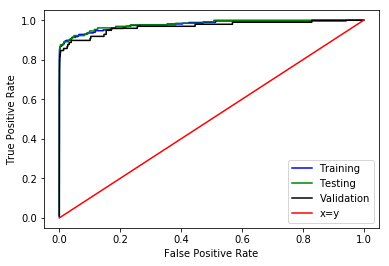

In [11]:
plt.plot(roc_train[0], roc_train[1], 'b', label='Training')
plt.plot(roc_test[0], roc_test[1], 'g', label='Testing')
plt.plot(roc_val[0], roc_val[1], 'k', label='Validation')
plt.plot([0,1], [0,1], 'r', label='x=y')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

The curve here shows us visually that our rank ordering will be accurate. Moreover, if we decided that we wanted a specific prediction, we can see that we could easily set a threshold which would yield greater than an 80% true positive rate at the cost of very few false positives. We could also go higher depending on whether our expected losses justify the extra expenditure. (Remember that the actual fraud rate is very low- a false positive rate of 1% means we will flag 2800 records in our dataset that aren't fraudulent that we'll need to sort through by manual review. So the expected loss must be high.)

Given this, can we do better? To do so we need to enable more complex interactions between the variables than the simple linear ones in our logistic regression. We could do this by combining and crossing terms together, but a better option is to build a deep network and allow it to figure out the relationships for itself. We've already learned not to try to interpret the model parameters, so it's only one step further to move to a black box model.

We'll be using Keras as our programming framework of choice, with Tensorflow as the backend. Why not raw tensorflow? In enterprise contexts we care most about 3 things:
1. Models that are accurate enough to drive value.
2. Getting end to end as quickly as possible.
3. Iterating as quickly as possible.

This makes high level APIs very valuable for development purposes (the same reason that frameworks like Ruby On Rails are so popular for SaaS startups). We should be working with lower level libraries only if we find ourselves with a niche use case that really requires the extra flexibility, such that the extra developer time is worthwhile. We will also want to pick setting that allow us to fit and evaluate model performance quickly. This means limiting ourselves to moderately sized networks and fast fits (this tends to constrain the hyperparameter exploration we might do).

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l1_l2

Using TensorFlow backend.


In [13]:
# We're going to upweight the fraudulent data points. This will make it easier for the more general optimization
# techniques needed to fit a deep network to latch onto the results. This means we won't get a straight up probability
# measure back, but the rank ordering should still be preserved.
class_weight = {0:1, 1:499}

One of the interesting things to me about deep models is that they can be thought of as deconstructed Machine Learning models. A machine learning model basically consists of three parts:
- A calculation engine. In the LR model above, this is logistic function.
- An optimization method, also known as a learning algorithm. The default sklearn logistic regression uses the LIBLINEAR library, which implements the Trust Region Newton Method (see http://fa.bianp.net/blog/2013/numerical-optimizers-for-logistic-regression/ for more details).
- A cost function, also known as a loss function, which is the thing to be minimized by the optimization method. For the LR model we set up, this is least square + the L1 regularization term.

In deep models we need to declare all of these explicitly, which we'll do below.

In [14]:
# First we set up the model.

# There are several schools of thought on the number of units in a given layer. 
# I tend to use one of two rules of thumb:
# - ~0.5x the number of features or
# - ~2x the number of features in the input data.
num_units=50

# We'll be using a combination of l1 and l2 regularization. While random dropout is almost always valuable,
# regularization in the layers doesn't always help. It's imperative to check it. In this case regularization
# does help.
reg = l1_l2()

# Our model type here will be a set of connected layers. But this is really Keras boilerplate.
deep_model = Sequential()

# We'll be using rectified linear units (relus) for activation with a 20% dropout.
deep_model.add(Dense(num_units, input_dim=x_train.shape[1], 
                kernel_regularizer=reg, 
                activation='relu'))
deep_model.add(Dropout(0.2))

# Layer 2
deep_model.add(Dense(num_units, 
                kernel_regularizer=reg, 
                activation='relu'))
deep_model.add(Dropout(0.2))

# Layer 3
deep_model.add(Dense(num_units, 
                kernel_regularizer=reg, 
                activation='relu'))
deep_model.add(Dropout(0.2))

# Output!
deep_model.add(Dense(1, activation='sigmoid'))

In [15]:
# We'll use adaptive gradient descent (adagrad) for optimization, because it tends to produce better results with 
# fewer epochs. We'll use binary cross entropy, since this is a binary classification problem- a record is either 
# fraudulent or not.
deep_model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
deep_model.fit(
    x_train.values, 
    y_train.values, 
    batch_size=1024, 
    epochs=100,
    verbose=0, 
    class_weight=class_weight, 
    validation_data=(x_test.values, y_test.values))

In [22]:
deep_auc_train = metrics.roc_auc_score(y_train, deep_model.predict_proba(x_train.values))
deep_auc_test = metrics.roc_auc_score(y_test.values, deep_model.predict_proba(x_test.values))
deep_auc_val = metrics.roc_auc_score(outcomes_val.values, deep_model.predict_proba(features_val.values))
print()
print('AUC for the training set: %f' % deep_auc_train)
print('AUC for the test set: %f' % deep_auc_test)
print('AUC for the validation set: %f' % deep_auc_val)

73152/74999 [============================>.] - ETA: 0s
AUC for the training set: 0.974307
AUC for the test set: 0.980949
AUC for the validation set: 0.973629


The deep model does ~1% better than the LR model. Because of the low event rate this can be quite meaningful, although we would also need the value captured to be commensurate. Before we wrap, let's look at the visual.

In [19]:
deep_roc_train = metrics.roc_curve(y_train.values,deep_model.predict_proba(x_train.values))
deep_roc_test = metrics.roc_curve(y_test.values,deep_model.predict_proba(x_test.values))
deep_roc_val = metrics.roc_curve(outcomes_val.values,deep_model.predict_proba(features_val.values))

73952/74999 [============================>.] - ETA: 0s

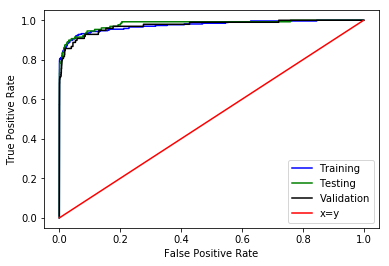

In [20]:
plt.plot(deep_roc_train[0], deep_roc_train[1], 'b', label='Training')
plt.plot(deep_roc_test[0], deep_roc_test[1], 'g', label='Testing')
plt.plot(deep_roc_val[0], deep_roc_val[1], 'k', label='Validation')
plt.plot([0,1], [0,1], 'r', label='x=y')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

And we can compare the validation curves for the two models directly:

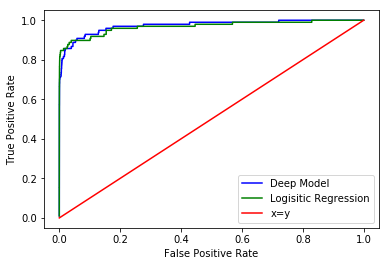

In [21]:
plt.plot(deep_roc_val[0], deep_roc_val[1], 'b', label='Deep Model')
plt.plot(roc_val[0], roc_val[1], 'g', label='Logisitic Regression')
plt.plot([0,1], [0,1], 'r', label='x=y')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

So there you have it. We've completed one use case, one commonly used in products and payments technology companies to identify fraudulent transactions. But this use case touches on one of the core issues we need to address in enterprise contexts: __In real world data sets, truthiness is squishy.__

What I mean by this is that in datasets like MNIST, there is a clear True/False condition in the training data- either an image is a 3 or it is not. Even with the labeled categorical data we still can't be completely sure of the True/False condition. A human might have mislabeled it, or the system determining the label could have been wrong. Moreover, in some cases (hospital admissions being a canonical one), even having a True label isn't quite accurate because having received that label is probabilistic. What this leads to is that the hardest part isn't the fitting of the models, or the deployment of the product (although there are parts of this that are annoyingly difficult), but rather the formulation of the problem. Until next time.